In [1]:
import os
import yaml

dir_path = 'chatterbotenglish'
files_list = os.listdir(dir_path + os.sep)

questions = list()
answers = list()
for filepath in files_list:
    stream = open( dir_path + os.sep + filepath , 'rb')
    docs = yaml.safe_load(stream)
    conversations = docs['conversations']
    for con in conversations:
        if len( con ) > 2 :
            questions.append(con[0])
            replies = con[ 1 : ]
            ans = ''
            for rep in replies:
                ans += ' ' + rep
            answers.append( ans )
        elif len( con )> 1:
            if type(con[0]) is dict:
                for k, v in con[0].items():
                    questions.append(k)
            else:                             
                questions.append(con[0])
            if type(con[1]) is dict:
                for k, v in con[1].items():
                    answers.append(k)
            else:                             
                answers.append(con[1])

In [2]:
import numpy as np
import tensorflow as tf
import pickle
from tensorflow.keras import layers , activations , models , preprocessing

print( tf.VERSION )

1.13.1


In [3]:
answers_lines = list()
for line in answers:
    answers_lines.append( '<START> ' + line + ' <END>' )

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts((questions + answers_lines))

In [6]:
import numpy as np
questions_seq = tokenizer.texts_to_sequences(questions)
max_input_length = max([len(seq) for seq in questions_seq])
encoder_input_data = pad_sequences( questions_seq , maxlen=max_input_length , padding='post' )

In [7]:
answers_seq = tokenizer.texts_to_sequences(answers_lines)
max_output_length = max([len(seq) for seq in answers_seq])
decoder_input_data = pad_sequences(answers_seq , maxlen=max_output_length , padding='post' )

In [8]:
decoder_target_data = list()
for token_seq in answers_seq:
    decoder_target_data.append( token_seq[ 1 : ] ) 

In [9]:
from keras.utils import to_categorical
num_tokens = len(tokenizer.word_index) + 1
padded_target_lines = pad_sequences( decoder_target_data , maxlen=max_output_length, padding='post' )
decoder_target_data  = to_categorical( padded_target_lines , num_tokens )

In [10]:
word_dict = tokenizer.word_index
max_question_len = encoder_input_data.shape[1]
max_answer_len = decoder_input_data.shape[1]

In [11]:
print( encoder_input_data.shape )
print( decoder_input_data.shape )
print( decoder_target_data.shape )

(566, 22)
(566, 74)
(566, 74, 1897)


In [12]:
# load the whole embedding into memory
import numpy as np
embeddings_index = dict()
f = open('/projects/glove.6B/glove.6B.200d.txt', encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [13]:
# vocabulary size
vocab_size = len(tokenizer.word_index) + 1 
EMBEDDING_DIM =200

word_index = tokenizer.word_index
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [14]:
import pickle
np.save('encoder_input_data', encoder_input_data) 
np.save('decoder_input_data', decoder_input_data) 
np.save('decoder_target_data', decoder_target_data) 
np.save('embedding_matrix', embedding_matrix) 
pickle.dump(tokenizer, open("tokenizer", "wb"))

In [15]:
import tensorflow as tf
encoder_inputs = tf.keras.layers.Input(shape=( None , ))
encoder_embedding = tf.keras.layers.Embedding( num_tokens, 200 , mask_zero=True , weights=[embedding_matrix] ) (encoder_inputs)
encoder_outputs , state_h , state_c = tf.keras.layers.LSTM( 200 , return_state=True )( encoder_embedding )
encoder_states = [ state_h , state_c ]

decoder_inputs = tf.keras.layers.Input(shape=( None ,  ))
decoder_embedding = tf.keras.layers.Embedding( num_tokens, 200 , mask_zero=True, weights=[embedding_matrix]) (decoder_inputs)
decoder_lstm = tf.keras.layers.LSTM( 200 , return_state=True , return_sequences=True )
decoder_outputs , _ , _ = decoder_lstm ( decoder_embedding , initial_state=encoder_states )
decoder_dense = tf.keras.layers.Dense( num_tokens , activation=tf.keras.activations.softmax ) 
output = decoder_dense ( decoder_outputs )

model = tf.keras.models.Model([encoder_inputs, decoder_inputs], output )
model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 200)    379400      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 200)    379400      input_2[0][0]                    
_____________________________________

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
# simple early stopping
#es = EarlyStopping(monitor='loss', mode='min', verbose=1)

In [17]:
#history = model.fit([encoder_input_data , decoder_input_data], decoder_target_data, batch_size=50, epochs=100, callbacks=[es]).history 
history = model.fit([encoder_input_data , decoder_input_data], decoder_target_data, batch_size=50, epochs=100).history 

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/100
566/566 [==============================] - 13s 23ms/sample - loss: 6.3983 - acc: 0.1004
Epoch 2/100
566/566 [==============================] - 10s 18ms/sample - loss: 5.6166 - acc: 0.1392
Epoch 3/100
566/566 [==============================] - 11s 19ms/sample - loss: 5.4740 - acc: 0.1514
Epoch 4/100
566/566 [==============================] - 10s 19ms/sample - loss: 5.3713 - acc: 0.1626
Epoch 5/100
566/566 [==============================] - 11s 20ms/sample - loss: 5.2345 - acc: 0.1712
Epoch 6/100
566/566 [==============================] - 12s 21ms/sample - loss: 5.1566 - acc: 0.1764
Epoch 7/100
566/566 [==============================] - 12s 21ms/sample - loss: 5.0551 - acc: 0.1852
Epoch 8/100
566/566 [==============================] - 11s 20ms/sample - loss: 4.9530 - acc: 0.1965
Epoch 9/100
566/566 [==============================] - 10s 18ms/sample - l

566/566 [==============================] - 10s 17ms/sample - loss: 0.4856 - acc: 0.9250
Epoch 77/100
566/566 [==============================] - 10s 17ms/sample - loss: 0.4643 - acc: 0.9268
Epoch 78/100
566/566 [==============================] - 10s 17ms/sample - loss: 0.4400 - acc: 0.9300
Epoch 79/100
566/566 [==============================] - 10s 17ms/sample - loss: 0.4296 - acc: 0.9314
Epoch 80/100
566/566 [==============================] - 10s 17ms/sample - loss: 0.4041 - acc: 0.9360
Epoch 81/100
566/566 [==============================] - 10s 17ms/sample - loss: 0.3883 - acc: 0.9401
Epoch 82/100
566/566 [==============================] - 10s 17ms/sample - loss: 0.3689 - acc: 0.9423
Epoch 83/100
566/566 [==============================] - 10s 17ms/sample - loss: 0.3622 - acc: 0.9433
Epoch 84/100
566/566 [==============================] - 10s 17ms/sample - loss: 0.3350 - acc: 0.9471
Epoch 85/100
566/566 [==============================] - 10s 17ms/sample - loss: 0.3237 - acc: 0.9499
Epo

In [18]:
model.save( 'model_chatbots1.h5' )
pickle.dump(history, open("history_chatbots1.p", "wb"))

# load it back
#model = load_model('model_chatbots1.h5')
#history = pickle.load(open("history_chatbots1.p", "rb"))

In [58]:
def make_inference_models():
    
    encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)
    
    decoder_state_input_h = tf.keras.layers.Input(shape=( 200 ,))
    decoder_state_input_c = tf.keras.layers.Input(shape=( 200 ,))
    
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding , initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = tf.keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    
    return encoder_model , decoder_model

In [59]:
def str_to_tokens( sentence : str ):
    words = sentence.lower().split()
    tokens_list = list()
    for word in words:
        tokens_list.append( word_dict[ word ] ) 
    return preprocessing.sequence.pad_sequences( [tokens_list] , maxlen=max_question_len , padding='post')

In [60]:
enc_model , dec_model = make_inference_models()

In [64]:
enc_model.save( 'enc_model.h5' )
dec_model.save( 'dec_model.h5' )

In [63]:
for _ in range(3):
    try:
        states_values = enc_model.predict( str_to_tokens( input( 'Enter question : ' ) ) )
        empty_target_seq = np.zeros( ( 1 , 1 ) )
        empty_target_seq[0, 0] = word_dict['start']
        stop_condition = False
        decoded_translation = ''
        while not stop_condition :
            dec_outputs , h , c = dec_model.predict([ empty_target_seq ] + states_values )
            sampled_word_index = np.argmax( dec_outputs[0, -1, :] )
            sampled_word = None
            for word , index in word_dict.items() :
                if sampled_word_index == index :
                    decoded_translation += ' {}'.format( word )
                    sampled_word = word
        
            if sampled_word == 'end' or len(decoded_translation.split()) > max_answer_len:
                stop_condition = True
            
            empty_target_seq = np.zeros( ( 1 , 1 ) )  
            empty_target_seq[ 0 , 0 ] = sampled_word_index
            states_values = [ h , c ] 

        ans = [w for w in decoded_translation.split() if not w in ['end']]
        ans = ' '.join(ans)
        print(ans)
    except Exception as e:
        print("sorry, can't answer")

Enter question : hi
hello
Enter question : hi
hello
Enter question : hi
hello


In [24]:
#questions

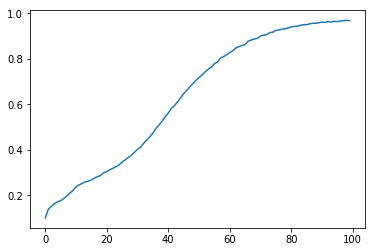

In [45]:
# Evaluation
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history['acc'])